# Course Project Part 1B - Air Quality Index (AQI) 
Part of the common analysis which involves estimating the impact of wildfire smoke on Gresham, Oregon, this notebook serves to calculate the AQI for Gresham, Oregon by pulling data from the US Environmental Protection Agency's API.

The purpose of this is to analyze the annual trends of AQI in Gresham, OR.

## Calculate AQI - US EPA Air Quality System API Example
This example illustrates how to request data from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. This is a historical API and does not provide real-time air quality data. The [documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) for the API provides definitions of the different call parameter and examples of the various calls that can be made to the API.

This notebook works systematically through example calls, requesting an API key, using 'list' to get various IDs and parameter values, and using 'daily summary' to get summary data that meets specific condistions. The notebook contains example function definitions that could be reused in other code. In general, the notebook explains each step along the way, referring back to possible output. Some of the explanations are tailored to the specific example requests of the API. Changing values to explore the results of the API is probably useful, but that will result in some explanations being out of sync with the outputs.

The US EPA was created in the early 1970's. The EPA reports that they only started broad based monitoring with standardized quality assurance procedures in the 1980's. Many counties will have data starting somewhere between 1983 and 1988. However, some counties still do not have any air quality monitoring stations. The API helps resolve this by providing calls to search for monitoring stations and data using either station ids, or a county designation or a geographic bounding box. This example code provides examples of the county based and bounding box based API calls. Some [additional information on the Air Quality System can be found in the EPA FAQ](https://www.epa.gov/outdoor-air-quality-data/frequent-questions-about-airdata) on the system.

The end goal of this example is to get to some values that we might use for the Air Quality Index or AQI. You might see this reported on the news, most often around smog, but more frequently with regard to smoke. The AQI index is meant to tell us something about how healthy or clean the air is on any day. The AQI is actually a somewhat complext measure. When I started this example I looked up [how to calculate the AQI](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) so that I would know roughly what goes into that value.


## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 16, 2024



In [ ]:
#
#    IMPORTS
# 

import os, json, time
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np
import re
from datetime import datetime

In [185]:
USERNAME = "your-email@uw.edu"
APIKEY = "yourkey"

In [186]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



# Making a list request
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program in `epa_air_quality_history_example.ipynb`

Once you have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. This API approach is probably better than having the EPA publish documentation that may be out of date as soon as it hits a web page. The one problem here is that some of the responses rely on jargon or terms-of-art. That is, one needs to know a bit about the way atmospheric sciece works to understand some of the terms. ... Good thing we can use the web to search for terms we don't know!

In [187]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program in `epa_air_quality_history_example.ipynb`

We're interested in getting to something that might be the Air Quality Index (AQI). You see this reported on the news - often around smog values, but also when there is smoke in the sky. The AQI is a complex measure of different gasses and of the particles in the air (dust, dirt, ash ...).

From the list produced by our 'list/Classes' request above, it looks like there is a class of sensors called "AQI POLLUTANTS". Let's try to get a list of those specific sensors and see what we can get from those.

In [188]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [189]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor. 

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

What I did below was to break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [190]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

In [191]:
#
#
# MODIFIED TO MY ASSIGNED CITY
CITY_LOCATIONS = {
    'gresham' :     {'city'   : 'Gresham',
                       'county' : 'Clatsop',
                       'state'  : 'Oregon',
                       'fips'   : '41051',
                       'latlon' : [45.5045, 122.4357] }
}


Given our CITY_LOCATIONS (modified to my assigned city) constant we can now find which monitoring locations are nearby. One option is to use the county to define the area we're interest in. You can get the EPA to list their monitoring stations by county.

In [192]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY 
request_data['state'] = CITY_LOCATIONS['gresham']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['gresham']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": null
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0010",
        "value_represented": null
    },
    {
        "code": "0011",
        "value_represented": null
    },
    {
        "code": "0012",
        "value_represented": null
    },
    {
        "code": "0013",
        "value_represented": null
    },
    {
        "code": "0014",
        "value_represented": null
    },
    

### ------ End code example from Dr. McDonald -------

## Daily Summary Requests

This function is set up to pull daily AQI summaries for particulate matter from the EPA's Air Quality System (AQS) API. The function is designed to make requests easy by setting up a template with fixed parameters, like location and types of particulate matter, and letting us adjust just the date range for each call. This makes it ideal for grabbing annual AQI data quickly.

#### API and Parameters
- **Purpose**: This function pulls daily AQI data specifically for PM10 and PM2.5. These pollutants are important because they’re among the best indicators of wildfire impacts on air quality, as wildfire smoke contains high levels of fine particles.
- **Location Codes**:
  - **State**: Oregon (FIPS code '41')
  - **County**: Multnomah County (FIPS code '051')
- **Parameters**:
  - PM10 Total 0-10µm (parameter code `81102`)
  - PM2.5 (parameter code `88101`)
  - Acceptable PM2.5 (parameter code `88502`)

#### Function: `get_daily_aqi_for_particulates`

The function goes through a range of years 1973-2021 (1973 because that's when they first started implementing monitors), making API calls each year to gather AQI data for PM10, PM2.5, and Acceptable PM2.5. 
### How it Works

1. **Data Collection**:
   - For each year, the function requests AQI data specific to our parameters, using Oregon’s and Multnomah County’s location codes.
   - **Why PM10 and PM2.5?** These [particles](https://www.airnow.gov/aqi/aqi-basics/) are chosen because they’re the best AQI indicators for wildfires, which release fine particulate matter that significantly impacts air quality. The [Environmental Protection Agency](https://www.epa.gov/indoor-air-quality-iaq/wildfires-and-indoor-air-quality-iaq) identifies PM2.5 as the primary pollutant in wildfire smoke. 

2. **Error Handling and Status Checks**:
   - The function checks the response status from the API each time.
   - If the data loads successfully, it saves AQI values for each pollutant; otherwise, it notes any issues.

3. **Throttling**:
   - A 1-second delay between requests is added to make sure we stay within API rate limits.

Overall, this setup ensures that the function handles errors gracefully, works efficiently, and captures the most relevant AQI indicators for assessing wildfire smoke impact.


In [193]:
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty'   

# parameters PM2.5 and PM10 AQI
AQI_PARAMS_PARTICULATES = "81102,88101,88502"  # PM10 Total, PM2.5, Acceptable PM2.5

# get daily AQI data by year for specific parameters
def get_daily_aqi_for_particulates(start_year=1973, end_year=2021):
    aqi_data = []  
    
    for year in range(start_year, end_year + 1):
        pm10_aqi = None
        pm25_aqi = None
        acceptable_pm25_aqi = None
        
        # set up request with only required parameters for the API call
        request_data = {
            'email': USERNAME,
            'key': APIKEY,
            'state': '41',          # Oregon state FIPS code
            'county': '051',        # Multnomah County FIPS code
            'param': AQI_PARAMS_PARTICULATES,  # Particulate parameters
            'bdate': f"{year}0101",  # Begin date for the year
            'edate': f"{year}1231"   # End date for the year
        }

        response = requests.get(API_REQUEST_URL + API_ACTION_DAILY_SUMMARY_COUNTY, params=request_data)
        
        if response.status_code == 200:
            data = response.json()
            if data['Header'][0]['status'] == "Success":
                print(f"Retrieved data for year {year}:")
                for record in data['Data']:
                    # get the AQI for each particulate parameter and assign to the corresponding variable
                    if record['parameter_code'] == "81102":  # PM10
                        pm10_aqi = record.get('aqi')
                    elif record['parameter_code'] == "88101":  # PM2.5
                        pm25_aqi = record.get('aqi')
                    elif record['parameter_code'] == "88502":  # Acceptable PM2.5
                        acceptable_pm25_aqi = record.get('aqi')
                
                # append the collected AQI values for the year to the list
                aqi_data.append({
                    "Year": year,
                    "PM10_AQI": pm10_aqi,
                    "PM2.5_AQI": pm25_aqi,
                    "Acceptable_PM2.5_AQI": acceptable_pm25_aqi
                })
                
            else:
                print(f"No data available for year {year}: {data['Header'][0]['status']}")
        else:
            print(f"Failed to retrieve data for year {year}: {response.text}")
        
        time.sleep(1) 

    return pd.DataFrame(aqi_data)

aqi_df = get_daily_aqi_for_particulates(start_year=1973, end_year=2021)
aqi_df.to_csv("particulate_aqi_summary.csv", index=False)

No data available for year 1973: No data matched your selection
No data available for year 1974: No data matched your selection
No data available for year 1975: No data matched your selection
No data available for year 1976: No data matched your selection
No data available for year 1977: No data matched your selection
No data available for year 1978: No data matched your selection
No data available for year 1979: No data matched your selection
No data available for year 1980: No data matched your selection
No data available for year 1981: No data matched your selection
Retrieved data for year 1982:
Retrieved data for year 1983:
Retrieved data for year 1984:
Retrieved data for year 1985:
Retrieved data for year 1986:
Retrieved data for year 1987:
Retrieved data for year 1988:
Retrieved data for year 1989:
Retrieved data for year 1990:
Retrieved data for year 1991:
Retrieved data for year 1992:
Retrieved data for year 1993:
Retrieved data for year 1994:
Retrieved data for year 1995:
Retr

### Getting Annual AQI
I chose the highest AQI as the annual AQI because according to the [World Health Organization](https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health), air quality indices often report the “worst-case” pollutant, meaning the highest AQI among pollutants, as the representative value for a location. This practice provides a conservative measure of air quality, ensuring that the public is alerted to the most concerning pollutant level.

In [194]:
aqi_df['Max_AQI_Wildfire'] = aqi_df[['PM10_AQI', 'PM2.5_AQI']].max(axis=1)

aqi_df.to_csv("updated_aqi_summary.csv", index=False)
print(aqi_df)

    Year  PM10_AQI  PM2.5_AQI  Acceptable_PM2.5_AQI  Max_AQI_Wildfire
0   1982        27        NaN                   NaN              27.0
1   1983       108        NaN                   NaN             108.0
2   1984         9        NaN                   NaN               9.0
3   1985        56        NaN                   NaN              56.0
4   1986         9        NaN                   NaN               9.0
5   1987        25        NaN                   NaN              25.0
6   1988        18        NaN                   NaN              18.0
7   1989        56        NaN                   NaN              56.0
8   1990        38        NaN                   NaN              38.0
9   1991        32        NaN                   NaN              32.0
10  1992        17        NaN                   NaN              17.0
11  1993        18        NaN                   NaN              18.0
12  1994        21        NaN                   NaN              21.0
13  1995        35  

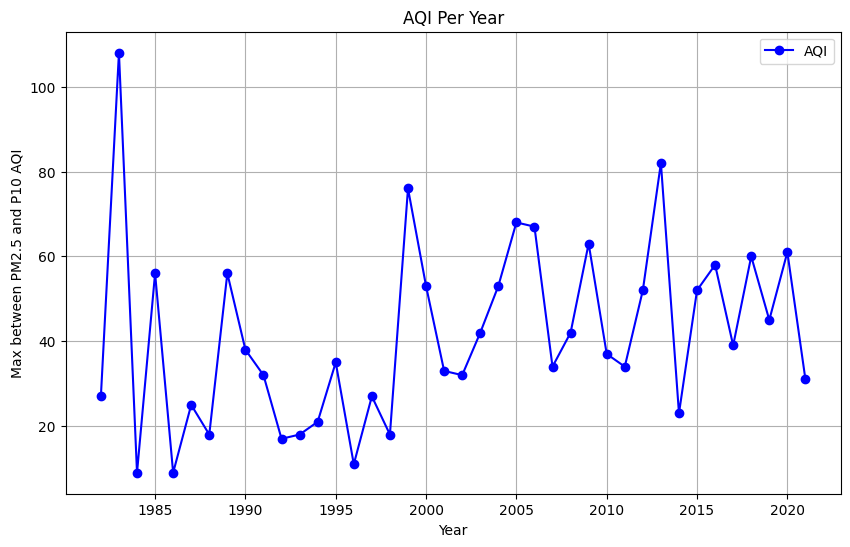

In [195]:
plt.figure(figsize=(10, 6))
plt.plot(aqi_df["Year"], aqi_df["Max_AQI_Wildfire"], marker='o', linestyle='-', color='b', label='AQI')
plt.title("AQI Per Year")
plt.xlabel("Year")
plt.ylabel("Max between PM2.5 and P10 AQI")
plt.legend()
plt.grid(True)
plt.show()
